In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import *
import math

In [2]:
data_dir = "data/Covid-19 Dataset"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
img_size = (224, 224)
batch_size = 16
image_limit = 150
steps_per_epoch = math.ceil(image_limit / batch_size)

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' ## this is actually a validation split
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 251 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


In [5]:
limited_train_gen = limited_image_generator(train_generator, image_limit)

In [6]:
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")

Class indices: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [7]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

images, labels = next(train_generator)

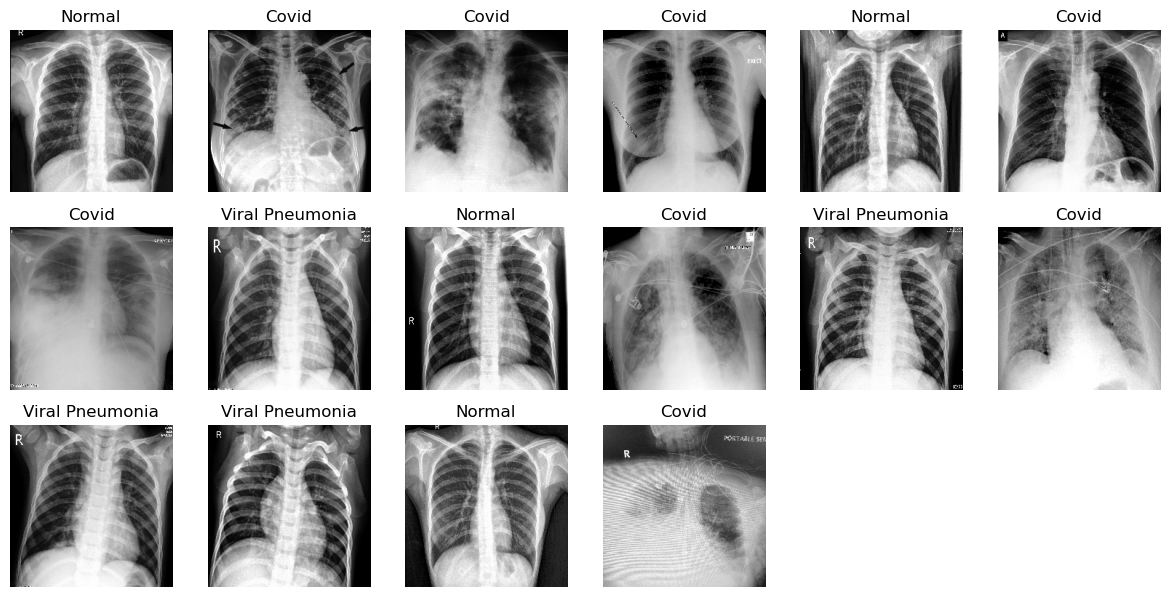

In [8]:
show_images(images, labels, class_names)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
base_model_history = model.fit(train_generator, epochs=20, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])


Epoch 1/20
10/10 [==============================] - 11s 974ms/step - loss: 2.6168 - accuracy: 0.3562 - val_loss: 1.7252 - val_accuracy: 0.6364
Epoch 2/20
10/10 [==============================] - 9s 928ms/step - loss: 1.3392 - accuracy: 0.7097 - val_loss: 1.0860 - val_accuracy: 0.6667
Epoch 3/20
10/10 [==============================] - 10s 926ms/step - loss: 0.8941 - accuracy: 0.8323 - val_loss: 0.9089 - val_accuracy: 0.8788
Epoch 4/20
10/10 [==============================] - 9s 869ms/step - loss: 0.7154 - accuracy: 0.8452 - val_loss: 0.6459 - val_accuracy: 0.9091
Epoch 5/20
10/10 [==============================] - 10s 960ms/step - loss: 0.5796 - accuracy: 0.8750 - val_loss: 0.6589 - val_accuracy: 0.8182
Epoch 6/20
10/10 [==============================] - 9s 903ms/step - loss: 0.4350 - accuracy: 0.9484 - val_loss: 0.6382 - val_accuracy: 0.8788
Epoch 7/20
10/10 [==============================] - 10s 956ms/step - loss: 0.4194 - accuracy: 0.9548 - val_loss: 0.5301 - val_accuracy: 0.8485
Ep

In [12]:
model.evaluate(test_generator)

3/3 [==============================] - 1s 186ms/step - loss: 0.5138 - accuracy: 0.8788


[0.513829231262207, 0.8787878751754761]

In [13]:
VGG16_layers = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG16_layers.trainable = False

In [14]:
VGG16_model = tf.keras.Sequential([
    VGG16_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
VGG16_history_pre_tuning = VGG16_model.fit(train_generator, epochs=15, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/15
10/10 [==============================] - 16s 1s/step - loss: 6.1930 - accuracy: 0.5290 - val_loss: 4.8286 - val_accuracy: 0.6667
Epoch 2/15
10/10 [==============================] - 15s 1s/step - loss: 3.4993 - accuracy: 0.7312 - val_loss: 1.9025 - val_accuracy: 0.7879
Epoch 3/15
10/10 [==============================] - 15s 1s/step - loss: 1.9899 - accuracy: 0.8581 - val_loss: 1.9482 - val_accuracy: 0.8182
Epoch 4/15
10/10 [==============================] - 15s 1s/step - loss: 1.6645 - accuracy: 0.9097 - val_loss: 2.0077 - val_accuracy: 0.7879
Epoch 5/15
10/10 [==============================] - 15s 1s/step - loss: 1.5973 - accuracy: 0.8813 - val_loss: 1.1223 - val_accuracy: 0.9697
Epoch 6/15
10/10 [==============================] - 15s 1s/step - loss: 1.1543 - accuracy: 0.9375 - val_loss: 1.0483 - val_accuracy: 0.9091
Epoch 7/15
10/10 [==============================] - 14s 1s/step - loss: 0.9920 - accuracy: 0.9484 - val_loss: 0.8877 - val_accuracy: 0.9697
Epoch 8/15
10/10 [==

In [17]:
VGG16_model.evaluate(test_generator)

3/3 [==============================] - 3s 650ms/step - loss: 0.5118 - accuracy: 0.9697


[0.5118432641029358, 0.9696969985961914]

In [18]:
VGG16_layers.trainable = True

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


In [19]:
VGG16_history_post_tuning = VGG16_model.fit(train_generator, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping]) 

Epoch 1/5
10/10 [==============================] - 50s 5s/step - loss: 0.4692 - accuracy: 0.9750 - val_loss: 0.6222 - val_accuracy: 0.8788
Epoch 2/5
10/10 [==============================] - 47s 5s/step - loss: 0.4813 - accuracy: 0.9806 - val_loss: 0.6274 - val_accuracy: 0.8485
Epoch 3/5
10/10 [==============================] - 45s 4s/step - loss: 0.4492 - accuracy: 0.9613 - val_loss: 0.4830 - val_accuracy: 0.9697
Epoch 4/5
10/10 [==============================] - 46s 5s/step - loss: 0.4243 - accuracy: 0.9871 - val_loss: 0.5502 - val_accuracy: 0.8485
Epoch 5/5
10/10 [==============================] - 46s 5s/step - loss: 0.4386 - accuracy: 0.9548 - val_loss: 0.4432 - val_accuracy: 0.9697


In [20]:
VGG16_model.evaluate(test_generator)

3/3 [==============================] - 2s 595ms/step - loss: 0.3756 - accuracy: 1.0000


[0.3755975663661957, 1.0]

In [21]:
Resnet50_layers = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [22]:
Resnet50_layers.trainable = False

In [23]:
Resnet50_model = tf.keras.Sequential([
    Resnet50_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [24]:
Resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 49,278,851
Trainable params: 25,691,139
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
Resnet50_history = Resnet50_model.fit(train_generator, epochs=15, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/15
10/10 [==============================] - 13s 958ms/step - loss: 10.6225 - accuracy: 0.4065 - val_loss: 5.6851 - val_accuracy: 0.3030
Epoch 2/15
10/10 [==============================] - 9s 845ms/step - loss: 9.1762 - accuracy: 0.4000 - val_loss: 2.8953 - val_accuracy: 0.6970
Epoch 3/15
10/10 [==============================] - 9s 846ms/step - loss: 5.2274 - accuracy: 0.5000 - val_loss: 0.8865 - val_accuracy: 0.7576
Epoch 4/15
10/10 [==============================] - 8s 805ms/step - loss: 1.7836 - accuracy: 0.6581 - val_loss: 0.8629 - val_accuracy: 0.8182
Epoch 5/15
10/10 [==============================] - 8s 815ms/step - loss: 1.1482 - accuracy: 0.6581 - val_loss: 0.9868 - val_accuracy: 0.7273
Epoch 6/15
10/10 [==============================] - 8s 817ms/step - loss: 1.0507 - accuracy: 0.7161 - val_loss: 0.8712 - val_accuracy: 0.7576
Epoch 7/15
10/10 [==============================] - 8s 829ms/step - loss: 1.1068 - accuracy: 0.7032 - val_loss: 0.8431 - val_accuracy: 0.7879
Epoc

In [26]:
Resnet50_model.evaluate(test_generator)

3/3 [==============================] - 1s 241ms/step - loss: 0.8486 - accuracy: 0.7576


[0.8485932946205139, 0.7575757503509521]

In [27]:
Densenet_layers = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
Densenet_layers.trainable = False

In [28]:
Densenet_model = tf.keras.Sequential([
    Densenet_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [29]:
Densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Densenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 19,883,587
Trainable params: 12,846,083
Non-trainable params: 7,037,504
_________________________________________________________________


In [30]:
Densenet_history_pre_tuning = Densenet_model.fit(train_generator, epochs=15, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/15
10/10 [==============================] - 16s 993ms/step - loss: 28.0343 - accuracy: 0.4903 - val_loss: 9.3185 - val_accuracy: 0.6364
Epoch 2/15
10/10 [==============================] - 8s 786ms/step - loss: 10.5681 - accuracy: 0.7125 - val_loss: 5.5424 - val_accuracy: 0.7879
Epoch 3/15
10/10 [==============================] - 8s 842ms/step - loss: 6.3120 - accuracy: 0.8323 - val_loss: 3.4023 - val_accuracy: 0.8788
Epoch 4/15
10/10 [==============================] - 8s 753ms/step - loss: 3.8613 - accuracy: 0.9226 - val_loss: 2.8675 - val_accuracy: 0.9697
Epoch 5/15
10/10 [==============================] - 8s 765ms/step - loss: 3.1393 - accuracy: 0.9625 - val_loss: 2.8044 - val_accuracy: 0.9394
Epoch 6/15
10/10 [==============================] - 8s 757ms/step - loss: 2.7184 - accuracy: 0.9375 - val_loss: 2.5021 - val_accuracy: 0.9697
Epoch 7/15
10/10 [==============================] - 8s 737ms/step - loss: 2.5628 - accuracy: 0.9419 - val_loss: 2.4034 - val_accuracy: 0.9394
Epo

In [31]:
Densenet_model.evaluate(test_generator)

3/3 [==============================] - 1s 184ms/step - loss: 1.4231 - accuracy: 0.9697


[1.4230992794036865, 0.9696969985961914]

In [32]:
Densenet_layers.trainable = True
Densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Densenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 19,883,587
Trainable params: 19,799,939
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
Densenet_history_post_tuning = Densenet_model.fit(train_generator, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/5
10/10 [==============================] - 32s 2s/step - loss: 4.1472 - accuracy: 0.6375 - val_loss: 1.3733 - val_accuracy: 0.9697
Epoch 2/5
10/10 [==============================] - 17s 2s/step - loss: 2.0391 - accuracy: 0.8581 - val_loss: 1.3814 - val_accuracy: 0.9697
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 1.5019 - accuracy: 0.9250 - val_loss: 1.3752 - val_accuracy: 0.9394
Epoch 4/5
 1/10 [==>...........................] - ETA: 18s - loss: 1.8256 - accuracy: 0.8125

In [34]:
Densenet_model.evaluate(test_generator)

3/3 [==============================] - 1s 228ms/step - loss: 6.4920 - accuracy: 0.7879


[6.492003440856934, 0.7878788113594055]

In [35]:
Mobilenet_layers = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
Mobilenet_layers.trainable = False

In [36]:
Mobilenet_model = tf.keras.Sequential([
    Mobilenet_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [37]:
Mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18,315,331
Trainable params: 16,057,347
Non-trainable params: 2,257,984
__________________________________

In [38]:
Mobilenet_history_pre_tuning = Mobilenet_model.fit(train_generator, epochs=15, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/15
10/10 [==============================] - 12s 809ms/step - loss: 16.4482 - accuracy: 0.6387 - val_loss: 9.0514 - val_accuracy: 0.8182
Epoch 2/15
10/10 [==============================] - 6s 652ms/step - loss: 6.6756 - accuracy: 0.8774 - val_loss: 6.4734 - val_accuracy: 0.8182
Epoch 3/15
10/10 [==============================] - 6s 607ms/step - loss: 4.9854 - accuracy: 0.9226 - val_loss: 3.9100 - val_accuracy: 0.9394
Epoch 4/15
10/10 [==============================] - 8s 780ms/step - loss: 4.5700 - accuracy: 0.9312 - val_loss: 4.2437 - val_accuracy: 0.8788
Epoch 5/15
10/10 [==============================] - 6s 603ms/step - loss: 3.3635 - accuracy: 0.9742 - val_loss: 3.5890 - val_accuracy: 0.8788
Epoch 6/15
10/10 [==============================] - 6s 610ms/step - loss: 3.5258 - accuracy: 0.9677 - val_loss: 4.0400 - val_accuracy: 0.8485
Epoch 7/15
10/10 [==============================] - 7s 654ms/step - loss: 3.5720 - accuracy: 0.9500 - val_loss: 5.3037 - val_accuracy: 0.8485
Epoc

In [39]:
Mobilenet_model.evaluate(test_generator)

3/3 [==============================] - 1s 157ms/step - loss: 2.4344 - accuracy: 1.0000


[2.434382677078247, 1.0]

In [40]:
Mobilenet_layers.trainable = True
Mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18,315,331
Trainable params: 18,281,219
Non-trainable params: 34,112
_____________________________________

In [41]:
Mobilenet_history_post_tuning = Mobilenet_model.fit(train_generator, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/5
10/10 [==============================] - 15s 1s/step - loss: 13.6560 - accuracy: 0.5097 - val_loss: 3.0056 - val_accuracy: 0.9394
Epoch 2/5
10/10 [==============================] - 9s 913ms/step - loss: 9.4392 - accuracy: 0.5935 - val_loss: 3.0299 - val_accuracy: 0.9091
Epoch 3/5
10/10 [==============================] - 10s 997ms/step - loss: 6.1937 - accuracy: 0.6812 - val_loss: 3.0475 - val_accuracy: 0.9091
Epoch 4/5
10/10 [==============================] - 10s 993ms/step - loss: 3.9633 - accuracy: 0.7677 - val_loss: 3.0644 - val_accuracy: 0.9091


In [42]:
Mobilenet_model.evaluate(test_generator)

3/3 [==============================] - 1s 236ms/step - loss: 2.3763 - accuracy: 1.0000


[2.3762855529785156, 1.0]

In [ ]:
VGG16_history = concatenate_histories(VGG16_history_pre_tuning, VGG16_history_post_tuning)
Densenet_history = concatenate_histories(Densenet_history_pre_tuning, Densenet_history_post_tuning)
Mobilenet_history = concatenate_histories(Mobilenet_history_pre_tuning, Mobilenet_history_post_tuning)

In [47]:
histories = {
    'Base Model': base_model_history.history,
    'VGG16': VGG16_history,
    'Resnet50': Resnet50_history.history,
    'Densenet': Densenet_history,
    'Mobilenet': Mobilenet_history}

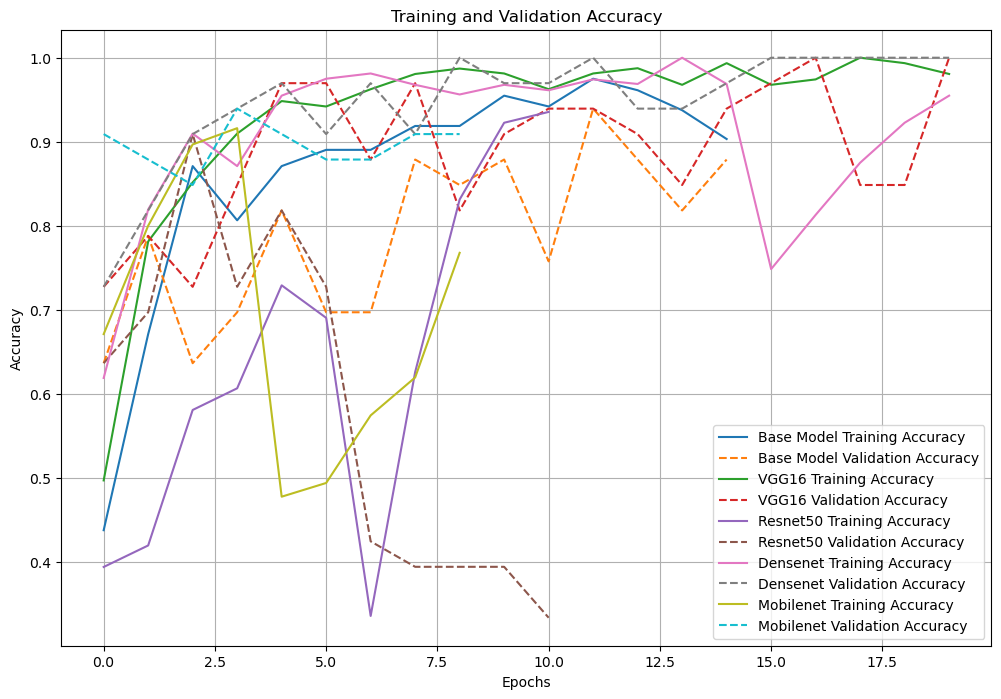

In [48]:
plot_accuracy(histories)

In [49]:
for name, history in histories.items():
    print("name:", name, "history:", type(history))

name: Base Model history: <class 'dict'>
name: VGG16 history: <class 'dict'>
name: Resnet50 history: <class 'dict'>
name: Densenet history: <class 'dict'>
name: Mobilenet history: <class 'dict'>


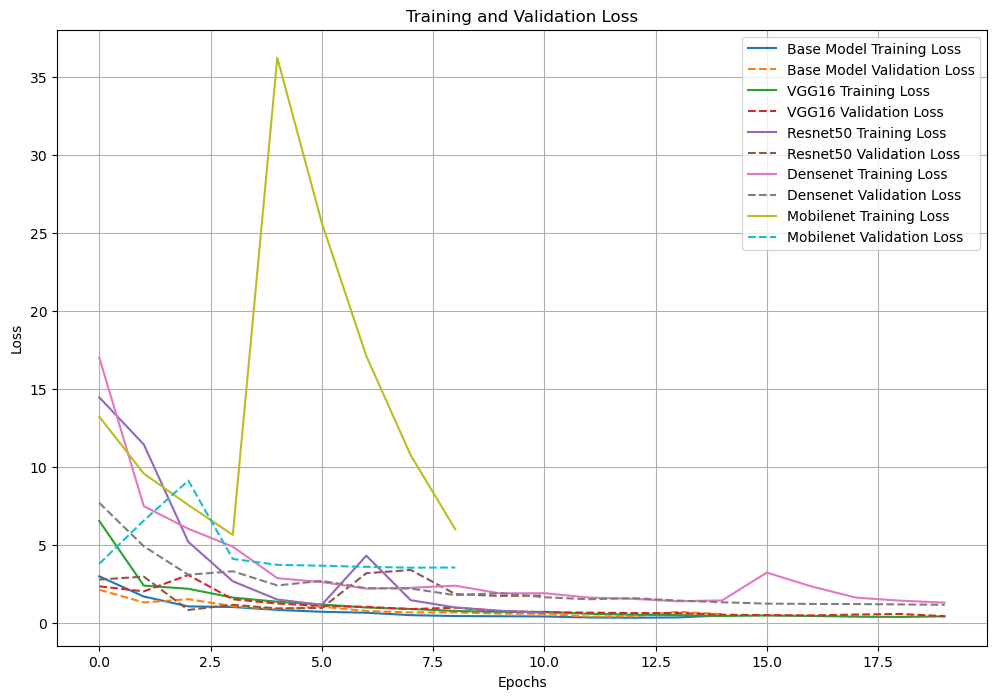

In [50]:
plot_loss(histories)

In [51]:
summarize_final_metrics(histories)

        Model  Final Training Accuracy  Final Validation Accuracy  \
0  Base Model                 0.903226                   0.878788   
1       VGG16                 0.980645                   1.000000   
2    Resnet50                 0.935484                   0.333333   
3    Densenet                 0.954839                   1.000000   
4   Mobilenet                 0.767742                   0.909091   

   Final Training Loss  Final Validation Loss  
0             0.448552               0.541592  
1             0.396172               0.405706  
2             0.618493               1.724331  
3             1.273430               1.135355  
4             5.975616               3.527122  
